In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy

sns.set(font_scale=1.5)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Scaffold Adaptability: BHRF1 Inhibitor

The aim of these experiments is to asses the ability to _structurally_ mimic the designed inhibitor of the _Epstein-Barr virus_ Apoptosis regulator [__BHRF1__](http://www.uniprot.org/uniprot/P0C6Z1), a homolog of human Bcl-2 proteins that block apoptosis and is associated with cancer. The designed inhibitor's structure can be found in the __PDB [4OYD](http://www.rcsb.org/pdb/explore.do?structureId=4OYD)__; and is based on the same binding motif as the one found in __PDB [2WH6](http://www.rcsb.org/pdb/explore.do?structureId=2WH6)__ and uses as template for the rest of the scaffold the structure of a three helical domain as found in __PDB [3LHP](http://www.rcsb.org/pdb/explore.do?structureId=3LHP)__.  
The key issue of this example is that the disposition of the 3 helix of the bundle need to change from 3LHP to 4OYD in order not to clash with BHRF1. Thus, we expect to show how, by generating the design on _FFL_ in the presence of the binder, we will be able to promote this conformational change, showcasing the importance of this new feature in our protocol. This expected clash can be observed when superimposing BHRF1 to the 3LHP scaffold through the binding motif of 2WH6.  

|3LHP|4OYD|
|:------:|:------:|
|![template](README_files/min_rms2target_templateonly.png)|![target](README_files/min_rms2target_targetonly.png)| 

### Measures  

Due to the type of conformational change that we are trying to evaluate, __global RMSD__ (i.e. the best possible RMSD obtained from all structural alignments of the two proteins) is not an optimal way to evaluate how well we capture the necessary structural change. Thus, during this analysis, we will also evaluate what we will call __local RMSD__. This measure derives from alingning the structures through the binding motif (that does not change during the _FFL_ protocol) and evaluate the RMSD without re-doing the alignment. This measure captures with higher accuracy the change of correlative disposition between the secondary structures.  

### Labeling 

|Label|Definition|
|:------|:------|
|__MOTIF__|Residues belonging to the functional query motif|
|__HOTSPOT__|Residues of the motif that are considered non-editable|
|__COLDSPOT__|Residues of the motif that are considered editable|
|__FLEXIBLE__|Residues of the motif's terminals that are allowed to explore alternative conformations|
|__TEMPLATE__|Residues of the design that do NOT belong to the query motif|
|__CONTEXT__|Residues belonging to other proteins in the complex that are NOT the design chain|

### Method Variants

For all these tests, we have divided the _FFL_ protocol into two parts:  
1. __The Folding:__ Managed by the __NubInitioMover__.
2. __The RD cycle:__ The Relax/Design (RD) cycle tests different ways to generate the final desings from the re-folded poses.

###### classicFFL:  
    
|Label|PACK|DESIGN|BB|CHI|
|:------|:------:|:------:|:------:|:------:|
|__HOTSPOT__|-|-|-|-|
|__COLDSPOT__|X|X|-|X|
|__FLEXIBLE__|X|-|X|X|
|__TEMPLATE__|X|X|X|X|
|__CONTEXT__|-|-|-|-|  

###### fullDesign / minimize:  

|Label|PACK|DESIGN|BB|CHI|
|:------|:------:|:------:|:------:|:------:|
|__HOTSPOT__|-|-|X|X|
|__COLDSPOT__|X|X|X|X|
|__FLEXIBLE__|X|-|X|X|
|__TEMPLATE__|X|X|X|X|
|__CONTEXT__|-|-|X|X|  

(one uses _FastRelax_, the other uses _MinMover_)

###### minimizeBinderAlternate:  

(alternates one round of _classicFFL_ and one with the following profile)  

|Label|PACK|DESIGN|BB|CHI|
|:------|:------:|:------:|:------:|:------:|
|__HOTSPOT__|-|-|-|-|
|__COLDSPOT__|-|-|-|-|
|__FLEXIBLE__|-|-|-|-|
|__TEMPLATE__|-|-|-|-|
|__CONTEXT__|-|-|X|X|  

## A) Evaluating start-end variability

In order to do this comparisson, there are a couple of things we need to know:  
1. What is the global and local RMSD between 3LHP (start) and 4OYD (end)
    * Aligning the binding motif of 4OYD to the insertion region of 3LHP
    * We call this tvt as template_vs_target.
2. How much does 4OYD (end) can naturally change depending on different minimization protocols
    * This refers to apply the same R/D protocols (without sequence editing) that we will apply to our desings

In [3]:
tvt = rstoolbox.api.read_rosetta_silent("experiments/3lhp_vs_4oyd/3lhp_vs_4oyd")
definition = {
    "scores":{
        "description": "description", "GlobalRMSD": "GlobalRMSD", "LocalRMSD": "LocalRMSD",
        "LocalRMSDH": "LocalRMSDH", "LocalRMSDL": "LocalRMSDL",
    }
}
tvtDF = rstoolbox.api.process_from_definitions(tvt, definition)
tvtDF

,GlobalRMSD,LocalRMSD,LocalRMSDH,LocalRMSDL,description
0,1.605,2.351,2.197,1.711,3lhp_0001


In [46]:
experiments = ["classicFFL", "fullDesign", "minimize", "minimizeBinderAlternate"]
definition = {
    "scores":{
        "description": "description", "GlobalRMSD": "GlobalRMSD", "LocalRMSD": "LocalRMSD",
        "LocalRMSDH": "LocalRMSDH", "LocalRMSDL": "LocalRMSDL", "design_type": "experiment"
    }
}
logic = {
    "keep": ["description", "experiment", "GlobalRMSD", "condition", "test"],
    "split": [("LocalRMSD", "target"), ("LocalRMSDH", "helices"), ("LocalRMSDL", "corehelices") ],
    "names": ["rmsd", "rmsd_to"]
}
tmpDFL = []
for exp in experiments:
    tmp = rstoolbox.api.read_rosetta_silent("experiments/4oyd_moves/{0}".format(exp), exp)
    tmpDFL.append(rstoolbox.api.process_from_definitions(tmp, definition))
moves4oydDF = []
moves4oydDF.append(pd.concat(tmpDFL))
moves4oydDF[0] = moves4oydDF[0].assign(condition=pd.Series(["binder"]*len(moves4oydDF[0]["description"])).values)
moves4oydDF[0] = moves4oydDF[0].assign(test=pd.Series(["4oyd_moves"]*len(moves4oydDF[0]["description"])).values)
moves4oydDF.append(rstoolbox.api.split_columns(moves4oydDF[0], logic))

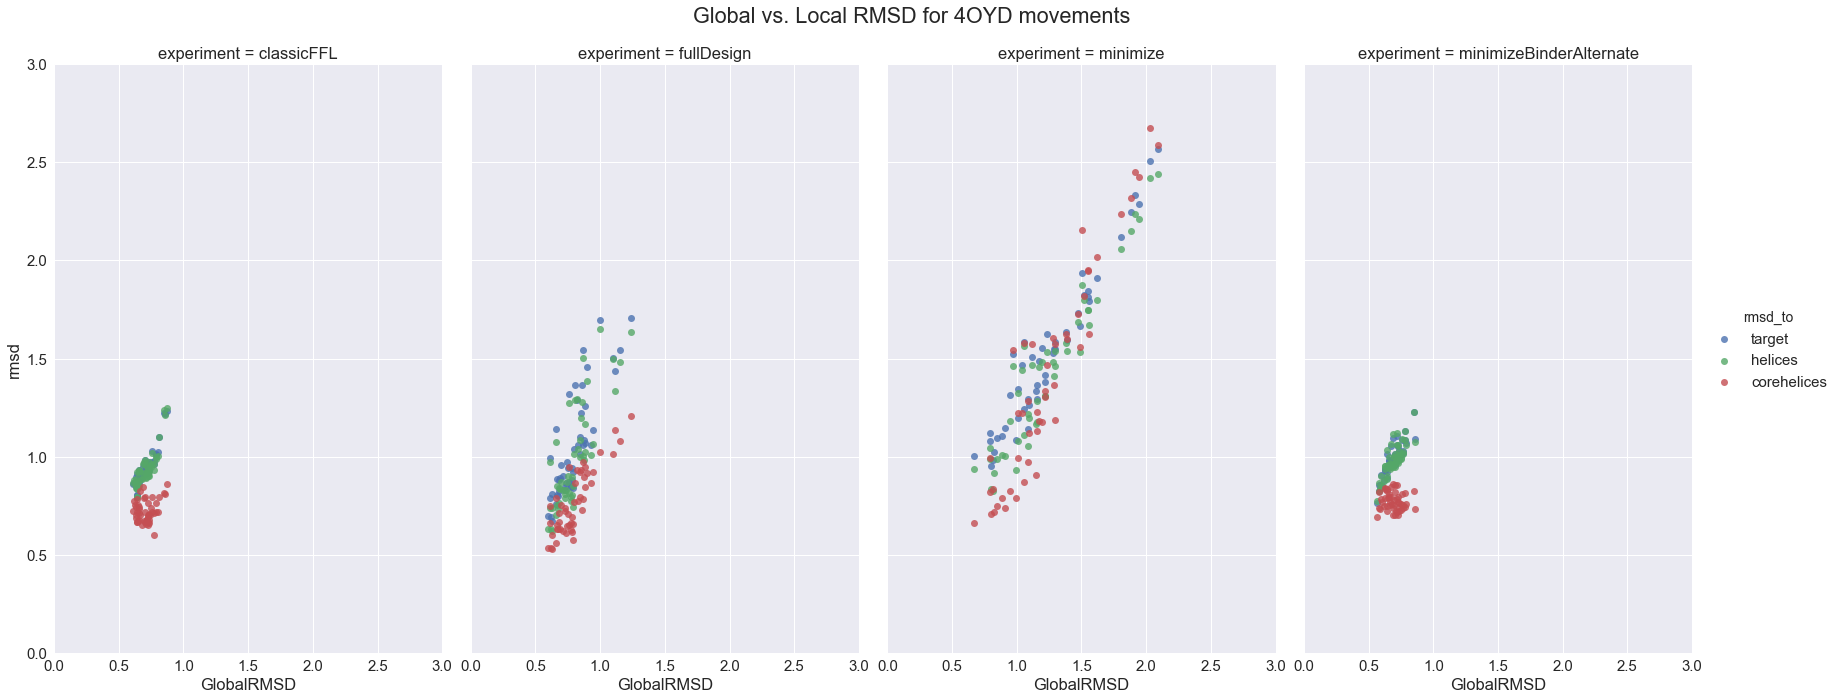

In [52]:
g = sns.FacetGrid(moves4oydDF[1], col="experiment", hue="rmsd_to", size=10, aspect=0.6, legend_out=True)
g = (g.map(sns.regplot, "GlobalRMSD", "rmsd", fit_reg=False).add_legend())
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,3)
g.axes[0,0].set_xlim(0,3)
g.fig.suptitle('Global vs. Local RMSD for 4OYD movements')
sns.plt.show()

## B) How close can we mimic 4OYD from itself?

Here we use 4OYD both as source of the _query motif and binder_ and as source of the _template_. This means that there is no need for the backbone to reajust to fit the binding site.  
For this experiment we only apply _classicFFL_.

In [60]:
conditions = ["nobinder", "binder"]
definition = {
    "scores":{
        "description": "description", "GRMSD2Target": "GlobalRMSD", "LRMSD2Target": "LocalRMSD",
        "LRMSDH2Target": "LocalRMSDH", "LRMSDLH2Target": "LocalRMSDL", "design_score": "score"
    },
    "naming": ["test", "", "condition", "", "", ""]
}
logic = {
    "keep": ["description", "experiment", "GlobalRMSD", "condition", "test", "score" ],
    "split": [("LocalRMSD", "target"), ("LocalRMSDH", "helices"), ("LocalRMSDL", "corehelices") ],
    "names": ["rmsd", "rmsd_to"]
}
tmpDFL = []
for cnd in conditions:
    tmp = rstoolbox.api.read_rosetta_silent("experiments/as4oyd/{0}/as4oyd_{0}_1_minisilent".format(cnd))
    tmpDFL.append(rstoolbox.api.process_from_definitions(tmp, definition))
as4oydDF = []
as4oydDF.append(pd.concat(tmpDFL))
as4oydDF[0] = as4oydDF[0].assign(experiment=pd.Series(["classicFFL"]*len(as4oydDF[0]["description"])).values)
as4oydDF.append(rstoolbox.api.split_columns(as4oydDF[0], logic))

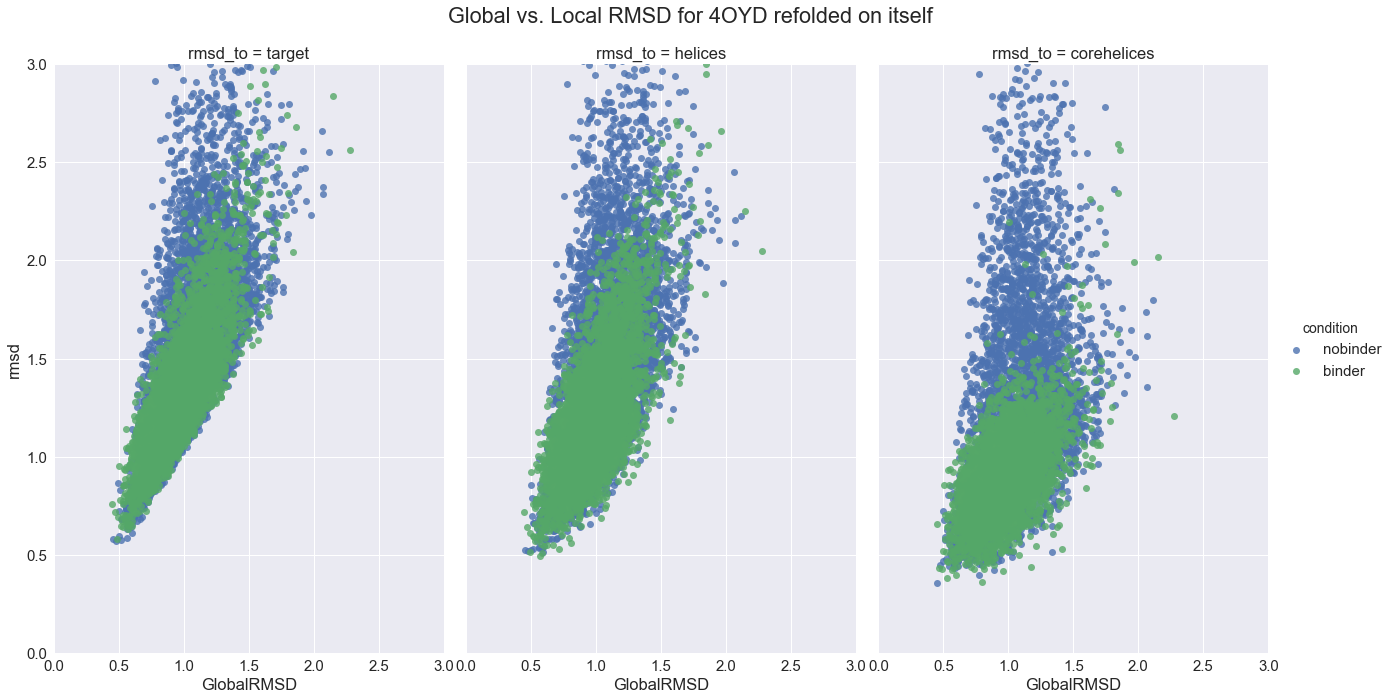

In [63]:
g = sns.FacetGrid(as4oydDF[1], col="rmsd_to", hue="condition", size=10, aspect=0.6, legend_out=True)
g = (g.map(sns.regplot, "GlobalRMSD", "rmsd", fit_reg=False).add_legend())
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,3)
g.axes[0,0].set_xlim(0,3)
g.fig.suptitle('Global vs. Local RMSD for 4OYD refolded on itself')
sns.plt.show()